# TP53 Methods - Sweep of All Proteins
After completing our first analysis, we decided to examine all of the proteins in our dataset to search for any potential changes in reponse to TP53 mutation. We were specifically looking for any changes only seen in the presence of a hotspot mutation

### Standard imports, including CPTAC package

In [1]:
import pandas as pd
import numpy as np
import re
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import CPTAC.Endometrial as CPTAC

Welcome to the CPTAC data service package. This import contains
information about the package. In order to access a specific data set,
import a CPTAC subfolder by either 'import CPTAC.DataName' or 'from
CPTAC import DataName'.
Loading Endometrial CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Acetylation Proteomics Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter embargo() to open the webpage for more details.


### Set up initial dataframes and variables

In [2]:
gene='TP53'
somatic = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()
transcriptomics = CPTAC.get_transcriptomics()

# A list of mutations present in the hotspot according to our Hotspot3D output
hotspot_mutations = ['p.P250L', 'p.R248W', 'p.S241C', 'p.241del','p.K164E', 'p.R249S', 'p.R273H', 'p.R282W',
                    'p.S127Y', 'p.G244D', 'p.A159P']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]

# Get a list of patient identifiers for those who have mutations in the hotspot
hotspot_patients_both_keys = mutated_hotspot[['Clinical_Patient_Key', 'Patient_Id']]
hotspot_patients = hotspot_patients_both_keys['Clinical_Patient_Key']
hotspot_patients

586      S001
1249     S006
1335     S008
3962     S016
4609     S020
44776    S071
44808    S072
46588    S082
49326    S096
49407    S097
Name: Clinical_Patient_Key, dtype: object

### Find number of patients with TP53 mutations in/outside of hotspot

In [3]:
print("Mutations inside hotspot: " + str(len(hotspot_patients)))
p53_mutated = somatic.loc[somatic['Gene'] == 'TP53']

# This naturally includes a value that is 'NA' so we subtract 1
# Some people have more than one mutation so we need to grab the unique values
num_mutated = len(set(p53_mutated['Clinical_Patient_Key'])) - 1
print("Total number of patients with mutations: " + str(num_mutated))

Mutations inside hotspot: 10
Total number of patients with mutations: 20


### Adjust significance cutoff using a Bonferroni correction

In [7]:
pcutoff = 0.05 / len(proteomics.columns)

## TP53 trans effects on all proteins (proteomic analysis)

### All mutations vs. cancer wildtype

In [5]:
significant_all_mut_wt = {}

# Go through every protein in our proteomics dataframe
for protein in proteomics.columns:
    if (protein != 'idx') and (protein != gene):
        # Create dataframe with mutation status of TP53 with proteomics of the given protein
        p53_mutations_protein = CPTAC.compare_mutations(proteomics, protein, gene)
        # Create a column showing the location of TP53 mutation
        p53_mutations_protein['Within_Hotspot'] = False
        p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = True
        p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Sample_Status'] == 'Tumor'].dropna(axis=0)
        # Perform the ttest if there is enough data for that protein
        mutated_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] != 'Wildtype']
        wt_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
        if len(mutated_tp53) < 2: continue
        ttest = scipy.stats.ttest_ind(mutated_tp53[protein], wt_tp53[protein])
        # Print significant values
        if ttest[1] <= pcutoff:
            significant_all_mut_wt[protein] = ttest[1]

print('Proteins with significant changes in abundance in the presence of any TP53 mutation (n=' + str(len(significant_all_mut_wt)) + '):\n')
significant_all_mut_wt

Proteins with significant changes in abundance in the presence of any TP53 mutation (n=156):



{'ABCF1': 1.8573708117589963e-06,
 'ABT1': 3.5171344108306085e-07,
 'AES': 1.9308430600012436e-06,
 'AKAP8L': 1.7456475608179158e-07,
 'ALG2': 2.086007970746945e-06,
 'ARFIP1': 1.1303242578934345e-06,
 'ARFIP2': 2.2772610708851248e-07,
 'ATAD2': 2.338445497230547e-07,
 'BIN3': 3.525984347712312e-06,
 'BIRC2': 6.889908460513658e-07,
 'BUB1B': 4.35664743913152e-06,
 'CA8': 1.1012913869348436e-06,
 'CAD': 1.7144110807622495e-07,
 'CBS': 3.801977363948052e-06,
 'CDK11B': 3.0141939988774142e-06,
 'CDKAL1': 5.27591042218303e-08,
 'CDYL': 2.3640407246542403e-06,
 'CEBPZ': 1.998449270891365e-07,
 'CHD4': 2.1872952483557406e-06,
 'CIP2A': 2.7089648165185354e-07,
 'CMPK2': 1.7839469548217545e-07,
 'CMSS1': 1.17276877752347e-07,
 'CMTR1': 7.804011750212554e-09,
 'COPS4': 4.3083335987084236e-07,
 'CRADD': 1.8603349367743644e-06,
 'CSE1L': 5.340696064900112e-07,
 'DDX18': 1.7393399324586305e-06,
 'DDX27': 1.5049556166838086e-07,
 'DDX39A': 3.34548743850025e-06,
 'DDX52': 1.5770610642258496e-07,
 'D

### Mutations outside of the hotspot vs. cancer wildtype

In [6]:
significant_nonhspt_wt = {}

# Go through every protein in our proteomics dataframe
for protein in proteomics.columns:
    if (protein != 'idx') and (protein != gene):
        # Create dataframe with mutation status of TP53 with proteomics of the given protein
        p53_mutations_protein = CPTAC.compare_mutations(proteomics, protein, gene)
        # Create a column showing the location of TP53 mutation
        p53_mutations_protein['Within_Hotspot'] = False
        p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = True
        p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Sample_Status'] == 'Tumor'].dropna(axis=0)
        # Perform the ttest if there is enough data for that protein
        mutated = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == False]
        wt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
        if len(mutated) < 2: continue
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        # Print significant values
        if ttest[1] <= pcutoff:
            significant_nonhspt_wt[protein] = ttest[1]

print('Proteins with significant changes in abundance in the presence of non-hotspot TP53 mutation (n=' + str(len(significant_nonhspt_wt)) + '):\n')
significant_nonhspt_wt

Proteins with significant changes in abundance in the presence of non-hotspot TP53 mutation (n=24):



{'BIRC2': 1.2402959880961902e-06,
 'CDKAL1': 2.480522955876094e-06,
 'COPS4': 1.6070306189634628e-06,
 'FASTKD5': 3.051850789236811e-06,
 'FXR1': 6.365321163144797e-07,
 'GEMIN2': 2.6733952055675324e-07,
 'GFM1': 7.11723234049833e-08,
 'GRB7': 1.5138105844806957e-06,
 'GXYLT1': 1.3367915036257628e-06,
 'HELZ2': 1.4234807751041673e-06,
 'KIF13B': 4.269243865919999e-06,
 'LSG1': 1.2318765765178466e-08,
 'MTHFD2': 1.4923211059935762e-09,
 'NGDN': 9.440553256413802e-07,
 'NOL10': 1.643659634370204e-07,
 'PRRC2A': 9.6446446278229e-07,
 'RBBP6': 1.962769989362497e-06,
 'SLC4A1AP': 2.2933787398940865e-08,
 'SNX7': 1.4250438824613118e-06,
 'STAT2': 4.2656321342186506e-07,
 'TRMT6': 7.328948976150925e-09,
 'VAV2': 2.598176758372159e-06,
 'VPS13C': 3.6724397751076377e-06,
 'WDR75': 3.389327690594331e-06}

### Hotspot mutations vs. cancer wildtype

In [9]:
significant_htspt_wt = {}

# Go through every protein in our proteomics dataframe
for protein in proteomics.columns:
    if (protein != 'idx') and (protein != gene):
        # Create dataframe with mutation status of TP53 with proteomics of the given protein
        p53_mutations_protein = CPTAC.compare_mutations(proteomics, protein, gene)
        # Create a column showing the location of TP53 mutation
        p53_mutations_protein['Within_Hotspot'] = False
        p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = True
        p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Sample_Status'] == 'Tumor'].dropna(axis=0)
        # Perform the ttest
        mutated_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == True]
        wt_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
        if len(mutated_tp53) < 2: continue
        ttest = scipy.stats.ttest_ind(mutated_tp53[protein], wt_tp53[protein])
        # Print significant values
        if ttest[1] <= pcutoff:
            significant_htspt_wt[protein] = ttest[1]
            
print('Proteins with significant changes in abundance in the presence of hotspot TP53 mutation (n=' + str(len(significant_htspt_wt)) + '):\n')
significant_htspt_wt

Proteins with significant changes in abundance in the presence of hotspot TP53 mutation (n=60):



{'ABT1': 4.498876981304671e-06,
 'AP1M2': 5.011231785069603e-07,
 'ARFIP2': 2.196231970915747e-06,
 'AURKA': 4.2195577094842487e-07,
 'CAD': 1.4242503917291054e-06,
 'CIP2A': 7.239547761803293e-07,
 'CMSS1': 5.902758007471886e-07,
 'CMTR1': 2.1603329082705716e-07,
 'DLGAP5': 6.064299470006698e-07,
 'ECT2': 1.4524321852251911e-06,
 'EIF2AK2': 7.118078104567006e-07,
 'ESF1': 7.0582229056475e-07,
 'FBXO22': 1.2275554464968474e-06,
 'FBXO3': 7.160403471268148e-07,
 'GALNT10': 3.649528055701452e-07,
 'GPATCH1': 2.9550258735939215e-06,
 'GRB7': 3.711077385074916e-07,
 'HELZ2': 9.558281697696534e-08,
 'HMCES': 4.097007649531414e-06,
 'IFIT2': 6.76726351339549e-08,
 'LSG1': 2.728601564153055e-06,
 'LSM14B': 1.194365662923036e-06,
 'MTHFD2': 1.2183806361662418e-07,
 'NOL11': 2.093154897039904e-06,
 'NOL7': 1.6321023721838165e-06,
 'NUP153': 1.4698948187815943e-06,
 'OGFR': 2.343094726139717e-08,
 'OSBPL2': 7.471833660580279e-07,
 'PAK2': 3.219519951291807e-06,
 'PKN1': 6.872245120120061e-08,
 '

## Identify the proteins for which hotspot mutations make a difference but other mutations do not

In [17]:
# Find proteins that are in the significant_htspt list but NOT in the significant_nonhotspot list
only_htspt = {k:v for k,v in significant_htspt_wt.items() if k not in significant_nonhspt_wt and k not in significant_all_mut_wt}

# Of these proteins, test for ones where there is a significant difference betwenn hotspot and non-hotspot mutations
hotspot_difference = {}
hotspot_cutoff = 0.05 
for protein, pval in only_htspt.items():
    # Create dataframe with mutation status of TP53 with proteomics of the given protein
    p53_mutations_protein = CPTAC.compare_mutations(proteomics, protein, gene)
    # Create a column showing the location of TP53 mutation
    p53_mutations_protein['Within_Hotspot'] = False
    p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = True
    p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
    p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Sample_Status'] == 'Tumor'].dropna(axis=0)
    # Perform the ttest
    hotspot_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == True]
    other_mut_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == False]
    if len(hotspot_tp53) < 2 or len(other_mut_tp53) < 2: continue
    ttest = scipy.stats.ttest_ind(hotspot_tp53[protein], other_mut_tp53[protein])
    # Print significant values
    if ttest[1] <= hotspot_cutoff:
        hotspot_difference[protein] = ttest[1]

hotspot_difference

{'AURKA': 0.01139622898036456,
 'FBXO3': 0.03515010600346557,
 'GALNT10': 0.02293080022619303,
 'OSBPL2': 0.034208575287998484,
 'PKN1': 0.012275023846947085}

## Plot these proteins

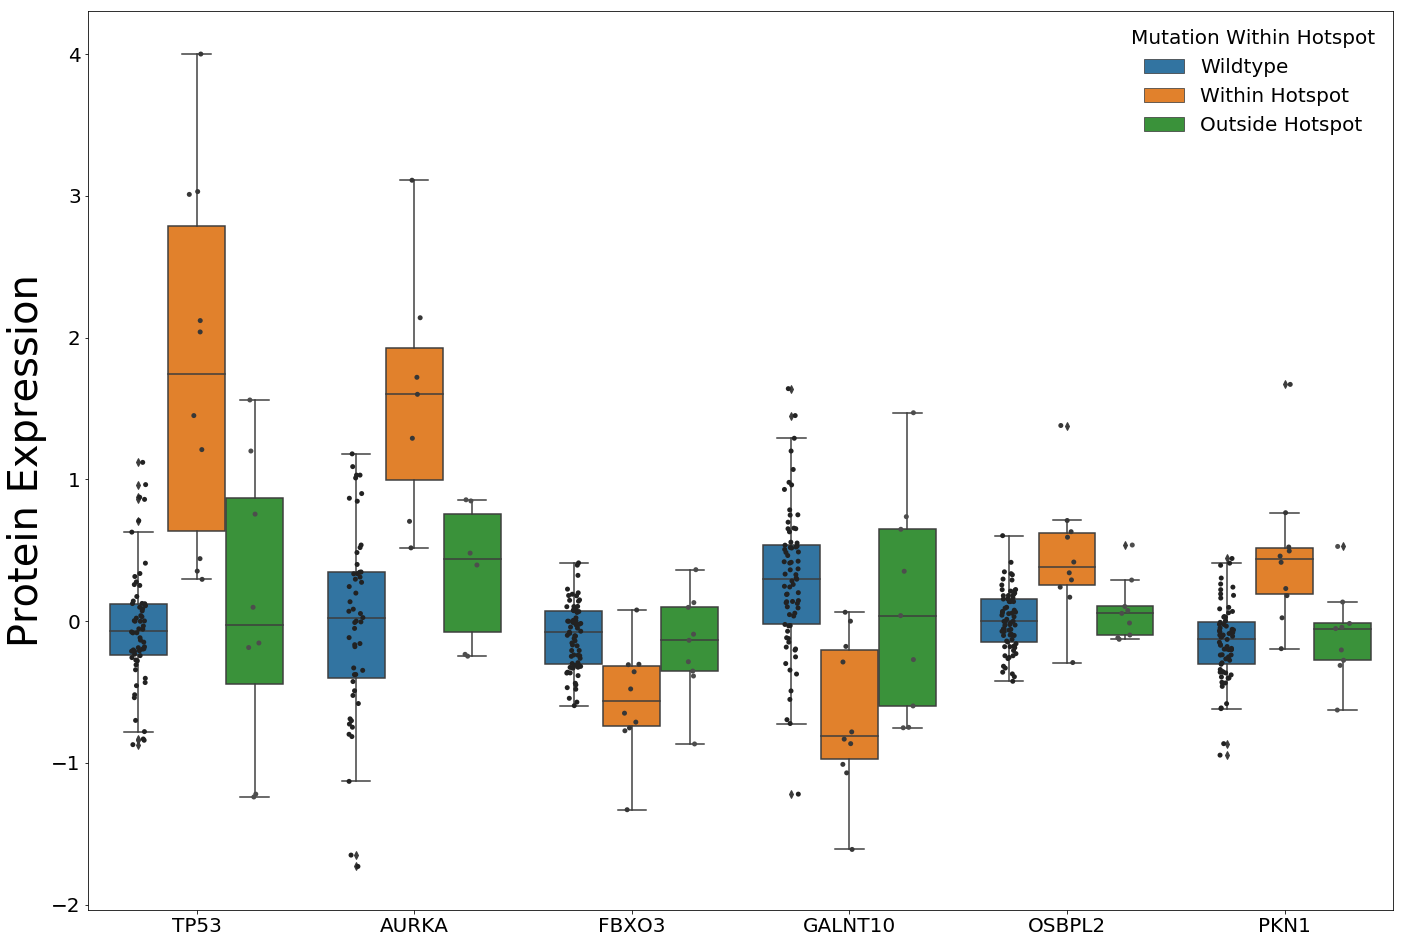

In [18]:
proteins_to_plot = []
for k, v in hotspot_difference.items():
    proteins_to_plot.append(k)

plotdf = CPTAC.compare_mutations(proteomics, gene)
plotdf = plotdf.loc[plotdf['Sample_Status'] == 'Tumor'][[gene, 'Mutation']]
for protein in proteins_to_plot:
    proteindf = CPTAC.compare_mutations(proteomics, protein, gene)[[protein]]
    plotdf = plotdf.join(proteindf)

plotdf['Within_Hotspot'] = 'Outside Hotspot'
plotdf.loc[hotspot_patients, 'Within_Hotspot'] = 'Within Hotspot'
plotdf.loc[plotdf['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
plotdf = pd.melt(plotdf, id_vars = ['Mutation', 'Within_Hotspot'], var_name = 'Protein', value_name = 'Proteomics')
plotdf = plotdf.dropna(axis = 0)

a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)

#Create the plot
boxplt = sns.boxplot(x='Protein', y='Proteomics', hue='Within_Hotspot', hue_order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], data=plotdf)
boxplt = sns.stripplot(data=plotdf, x='Protein', y='Proteomics', hue='Within_Hotspot', hue_order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Protein Expression', fontsize='40')
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:3], ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], title='Mutation Within Hotspot', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))

fig = boxplt.get_figure()
fig.savefig('hotspot_proteins.png', dpi=600)
plt.show()